# If we make a bad model, how close will it be to the "good" ones?

Most of us don't have a clear understanding of probabilities, especially when it comes to polling data. The more "sophisticated" the forecast, the more of a false confidence it can create in the certainty of the outcome.   

If all of these forecasts have corrected for 2016 or at least claim that they had a good model in 2016, then a poorly constructed model should have different results. 

### What are the odds the "sophisticated" models are bs?

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('ggplot')
random.seed(2016538)
np.random.seed(seed=2016538)

### We start by pulling in the state averages from RealClearPolitics

In [2]:
filename = 'election_polls_20200822.csv'
df = pd.read_csv(filename)

In [3]:
df = df[df['Poll'].str.startswith("RCP")].reset_index(drop=True)

In [4]:
df.head()

,State,Poll,Date,SampleSize,Segment,MoE,Biden (D),Trump (R),Spread
0,mo,RCP Average,5/26 - 7/1,--,NaN,--,43.3,49.7,Trump +6.4
1,mi,RCP Average,7/25 - 8/9,--,NaN,--,48.7,42.0,Biden +6.7
2,oh,RCP Average,6/24 - 7/24,--,NaN,--,47.0,44.7,Biden +2.3
3,ia,RCP Average,4/30 - 8/3,--,NaN,--,45.0,46.7,Trump +1.7
4,mn,RCP Average,7/18 - 8/18,--,NaN,--,49.3,44.0,Biden +5.3


### Probabilities the easy way   
To get state probabilites, we will divide a candidate's polling average by the sum of biden plus trump

In [5]:
df['biden'] = df['Biden (D)'] / (df['Biden (D)']+df['Trump (R)'])
df['trump'] = df['Trump (R)'] / (df['Biden (D)']+df['Trump (R)'])

In [6]:
df[['State','biden','trump']].head()

,State,biden,trump
0,mo,0.465591,0.534409
1,mi,0.536935,0.463065
2,oh,0.512541,0.487459
3,ia,0.490731,0.509269
4,mn,0.528403,0.471597


### Analysis is hard so use the 2016 election instead  
Some states are missing polling data, so we will use the 2016 results.

In [7]:
url = 'https://raw.githubusercontent.com/TheEconomist/us-potus-model/master/data/potus_results_76_16.csv'
df2 = pd.read_csv(url)
df2 = df2[df2['year'] == 2016]
df2['State'] = df2['state'].str.lower()

In [8]:
df = df2.set_index('State').join(df.set_index('State'))

In [9]:
df.loc[(df['biden'].isnull()),'biden'] = df.dem / (df.dem + df.rep)
df.loc[(df['trump'].isnull()),'trump'] = df.rep / (df.dem + df.rep)

### Add electoral college votes per state

In [10]:
ec = {'mt':3,'sc':9,'tx':38,'me':4,'nc':15, 'co':9, 'nv':6, 'tn':11, 'az':11, 'ny':29, 'wi':10,
      'ga':16, 'fl':29, 'ar':6, 'oh':18, 'va':13, 'ut':6, 'mn':10, 'nm':5, 'nj':14, 'ks':6, 'ky':8,
      'ms':6, 'wa':12, 'mo':10, 'in':11, 'al':9, 'ma':11, 'nh':4, 'de':3, 'ia':6, 'ca':55, 'mi':16,
      'pa':20, 'ak':3, 'ct':7, 'wy' : 3, 'wv' : 5, 'vt': 3, 'sd' : 3, 'ri' : 4, 'or' : 7, 'ok' : 7,
      'nd' : 3, 'ne' : 5, 'md' : 10, 'la' : 8, 'il' : 20, 'id' : 4, 'hi': 4, 'dc': 3}
ec =  {k.upper(): v for k, v in ec.items()}

In [11]:
df['ec'] = df["state"].map(lambda x:ec[x])

In [12]:
df[['ec','biden','trump']].head()

,ec,biden,trump
State,,,
ak,3,0.416143,0.583857
al,9,0.356259,0.643741
ar,6,0.357149,0.642851
az,11,0.510870,0.489130
ca,55,0.667774,0.332226


### Sounding fancy applying Stats 101 basics  
Since polls have a 95% confidence interval, so will our simulation.   
We will also give each state a normally distributed margin of error at +-3%

In [13]:
def electoral_college(ec, cand, state, sims=40000):
    cand_wins = 0
    cand_ec_total = []
    cand_states = []
    for i in range(sims):
        cand_ec = 0
        cand_state = []
        for x, y, z in zip(cand, states, ec):
            sim_election = np.random.uniform(low=0.025,high=.975)
            moe_x = np.random.normal(0.03,.1)
            x1 = moe_x + x
            if x1 > sim_election:
                cand_ec += z
                cand_state.append(y)
        cand_ec_total.append(cand_ec)
        cand_states.append(cand_state)
        if cand_ec > 269:
            cand_wins += 1
    return cand_wins, cand_ec_total, cand_states

### Borrow from the Seer of Seers, Sage of Sages, Prognosticator of Prognosticators 
Nate Silver at FiveThirtyEight claimed to have one of the most accurate forecasts of 2016.   
This election, he did 40,000 simulations so we will do the same.

In [14]:
print("40,000 Simulations of the Election")
print()
sims = 40000
ec = list(df.ec.values)
states = list(df.state.values)
cand_1 = list(df['biden'].values)
cand_1_wins, cand_1_ec_totals, cand_1_states = electoral_college(ec, cand_1, states, sims=sims)
cand_2_ec_totals = [538 - x for x in cand_1_ec_totals]
print('Biden Win Probability:', round((cand_1_wins/sims)*100))
print()
print('Trump Win Probability:', round(((sims - cand_1_wins)/sims)*100))
print()

40,000 Simulations of the Election

Biden Win Probability: 73

Trump Win Probability: 27



### Guess who else has those odds...

![538](https://raw.githubusercontent.com/ahoaglandnu/election2020/master/graphics/538.png)

How...how is that even possible? My methodology is basically derivative nonsense.

### Examining the results of 40,000 simulations

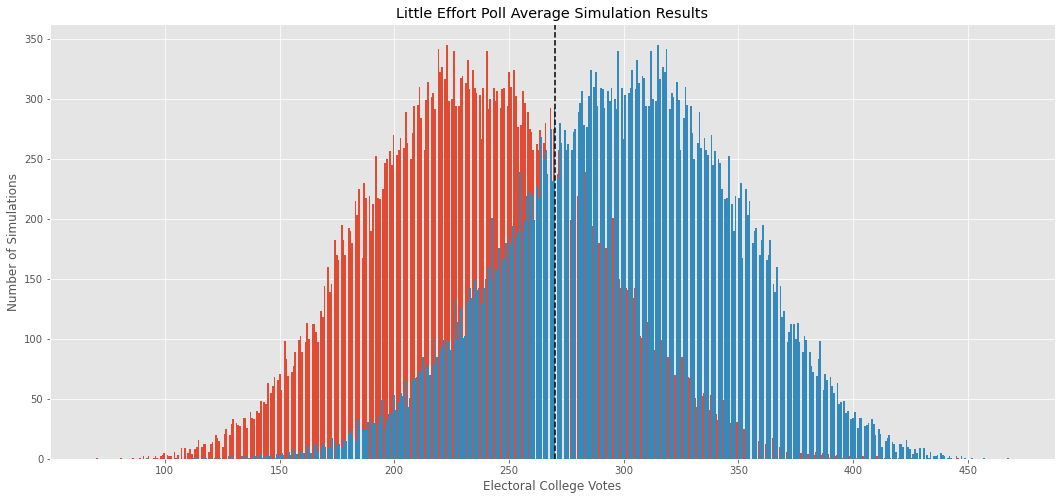

In [15]:
plt.figure(figsize=(18,8))
plt.hist(cand_2_ec_totals,500)
plt.hist(cand_1_ec_totals,500)
plt.axvline(x=270, color='k', linestyle='dashed')
plt.xlabel('Electoral College Votes')
plt.ylabel('Number of Simulations')
plt.title('Little Effort Poll Average Simulation Results')
plt.show()

### So what's the actual forecast?
The peaks are of interest so we will see what the two most frequent results were.

In [16]:
for i,j in Counter(cand_1_ec_totals).most_common(n=2):
    print('Electoral College Results: Biden',i)
print()
for i,j in Counter(cand_2_ec_totals).most_common(n=2):
    print('Electoral College Results: Trump',i)

Electoral College Results: Biden 315
Electoral College Results: Biden 319

Electoral College Results: Trump 223
Electoral College Results: Trump 219


### Looks like we were pretty close to the 538 model yet again...

![538 ec](https://raw.githubusercontent.com/ahoaglandnu/election2020/master/graphics/538_ec.png)

Our second most common results are within 6 of Nate Silver's forecast.

# The Economist has a forecast too

They adjust their probabilities based on changes in national polling so we will do the same.

In 2016, Clinton won 48.2% of the popular vote.  

According to RealClearPolitics, Biden is averaging 49.8% nationally.  

In [17]:
print('Add to Biden for each state', 49.8 - 48.2)

Add to Biden for each state 1.5999999999999943


### Adjusting for national polling shift

In [18]:
df['biden'] = df['biden'] + ((49.8 - 48.2)/100)

### Matching margin of error
The Economist uses a larger margin of error so we will expand ours to +-5 to match theirs

In [19]:
def electoral_college(ec, cand, state, sims=40000):
    cand_wins = 0
    cand_ec_total = []
    cand_states = []
    for i in range(sims):
        cand_ec = 0
        cand_state = []
        for x, y, z in zip(cand, states, ec):
            sim_election = np.random.uniform(low=0.025,high=.975)
            moe_x = np.random.normal(0.05,.1)
            x1 = moe_x + x
            if x1 > sim_election:
                cand_ec += z
                cand_state.append(y)
        cand_ec_total.append(cand_ec)
        cand_states.append(cand_state)
        if cand_ec > 269:
            cand_wins += 1
    return cand_wins, cand_ec_total, cand_states

In [20]:
print("20,000 Simulations of the Election")
print()
sims = 40000
ec = list(df.ec.values)
states = list(df.state.values)
cand_1 = list(df['biden'].values)
cand_1_wins, cand_1_ec_totals, cand_1_states = electoral_college(ec, cand_1, states, sims=sims)
cand_2_ec_totals = [538 - x for x in cand_1_ec_totals]
print('Biden Win Probability:', round((cand_1_wins/sims)*100))
print()
print('Trump Win Probability:', round(((sims - cand_1_wins)/sims)*100))
print()

20,000 Simulations of the Election

Biden Win Probability: 85

Trump Win Probability: 15



### Using the RealClearPolitics polling data, we can get odds pretty close to the Economist

![economist](https://raw.githubusercontent.com/ahoaglandnu/election2020/master/graphics/econ_prob.png)

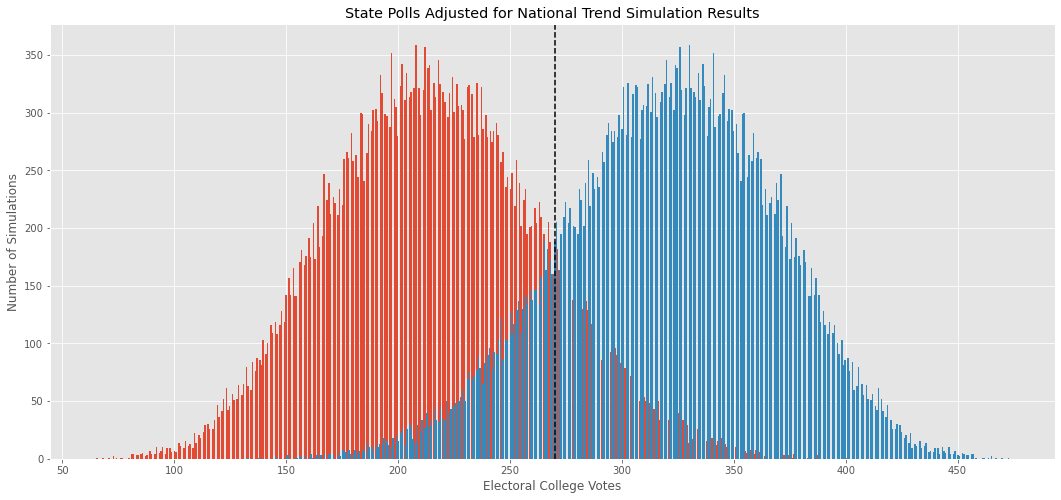

In [21]:
plt.figure(figsize=(18,8))
plt.hist(cand_2_ec_totals,500)
plt.hist(cand_1_ec_totals,500)
plt.axvline(x=270, color='k', linestyle='dashed')
plt.xlabel('Electoral College Votes')
plt.ylabel('Number of Simulations')
plt.title('State Polls Adjusted for National Trend Simulation Results')
plt.show()

### And our results?

In [22]:
print('Median Electoral College Results: Biden',np.median(cand_1_ec_totals))
print()
print('Median Electoral College Results: Trump',np.median(cand_2_ec_totals))

Median Electoral College Results: Biden 322.0

Median Electoral College Results: Trump 216.0


### Our median results are 21 or a state away from the Economist

![econ median](https://raw.githubusercontent.com/ahoaglandnu/election2020/master/graphics/econ_median.png)

### Conclusion

With little to no effort, we can come incredibly close to the same odds and projected electoral college outcome of some of the most well known election forecasts out there. Using terminology that the average person is not familiar with does not make the model any more accurate or sophisticated, it makes it misleading.

To quote Natalie Jackson:

> ...marketing probabilistic poll-based forecasts to the general public is at best a disservice to the audience, and at worst could impact voter turnout and outcomes.

You can read her full article here: [Poll-Based Election Forecasts Will Always Struggle With Uncertainty](https://centerforpolitics.org/crystalball/articles/poll-based-election-forecasts-will-always-struggle-with-uncertainty/)